# Identificação

**Turma:** 3DTS
**Professor:** MSc. Elthon Manhas de Freitas
**Grupo:**
* Cristian Fernandes - RM346664
* Gilberto Rodrigues - RM346938
* Thiago Pimentel - RM347130

# Estudo da base de dados
Este notebook tem por finalidade realizar um estudo da base para os seguintes propósitos
1. Entendimento do dataset
2. Ajuste das variáveis para aplicação dos modelos
3. Testes para identificação do melhor modelo para classificação do perfil dos clientes
4. Testes para identificação do melhor modelo para classificação da propensão à inadimplência

Este notebook serve apenas como estudo para definição do melhor pipeline para criação dos modelos. O arquivo Python que realiza a criação dos modelos está disponível no diretório training, sendo que as escolhas para criação do modelo foram baseada no estudo realizado neste notebook.

In [1]:
# imports
import numpy as np
import pandas as pd
import missingno as ms
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV

In [2]:
# seed global
seed = 42

## Análise das informações do modelo
O primeiro passo é realizar uma análise da base de dados para entender o seu conteúdo e prepará-la para a criação do modelo

In [3]:
# Carga da base
df = pd.read_csv('../base/loan_default.csv')
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co_applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
1,24932,2019,cf,Male,nopre,type3,p4,l1,nopc,nob/c,...,EQUI,765,EXP,45-54,to_inst,NaN,North,direct,1,NaN
2,25039,2019,cf,Male,nopre,type2,p3,l1,nopc,b/c,...,EQUI,880,EXP,35-44,to_inst,NaN,North,direct,1,NaN
3,25101,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EQUI,880,EXP,45-54,to_inst,NaN,central,direct,1,NaN
4,25110,2019,cf,Male,nopre,type3,p3,l1,nopc,nob/c,...,EQUI,768,EXP,45-54,not_inst,NaN,North,direct,1,NaN


In [4]:
# Informação geral do dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [5]:
# Percentual de valores nulos por coluna
print((df.isnull().sum() * 100 / len(df)).to_string())

ID                            0.000000
year                          0.000000
loan_limit                    2.249277
Gender                        0.000000
approv_in_adv                 0.610749
loan_type                     0.000000
loan_purpose                  0.090133
Credit_Worthiness             0.000000
open_credit                   0.000000
business_or_commercial        0.000000
loan_amount                   0.000000
rate_of_interest             24.509989
Interest_rate_spread         24.644515
Upfront_charges              26.664425
term                          0.027578
Neg_ammortization             0.081388
interest_only                 0.000000
lump_sum_payment              0.000000
property_value               10.155378
construction_type             0.000000
occupancy_type                0.000000
Secured_by                    0.000000
total_units                   0.000000
income                        6.154571
credit_type                   0.000000
Credit_Score             

<Axes: >

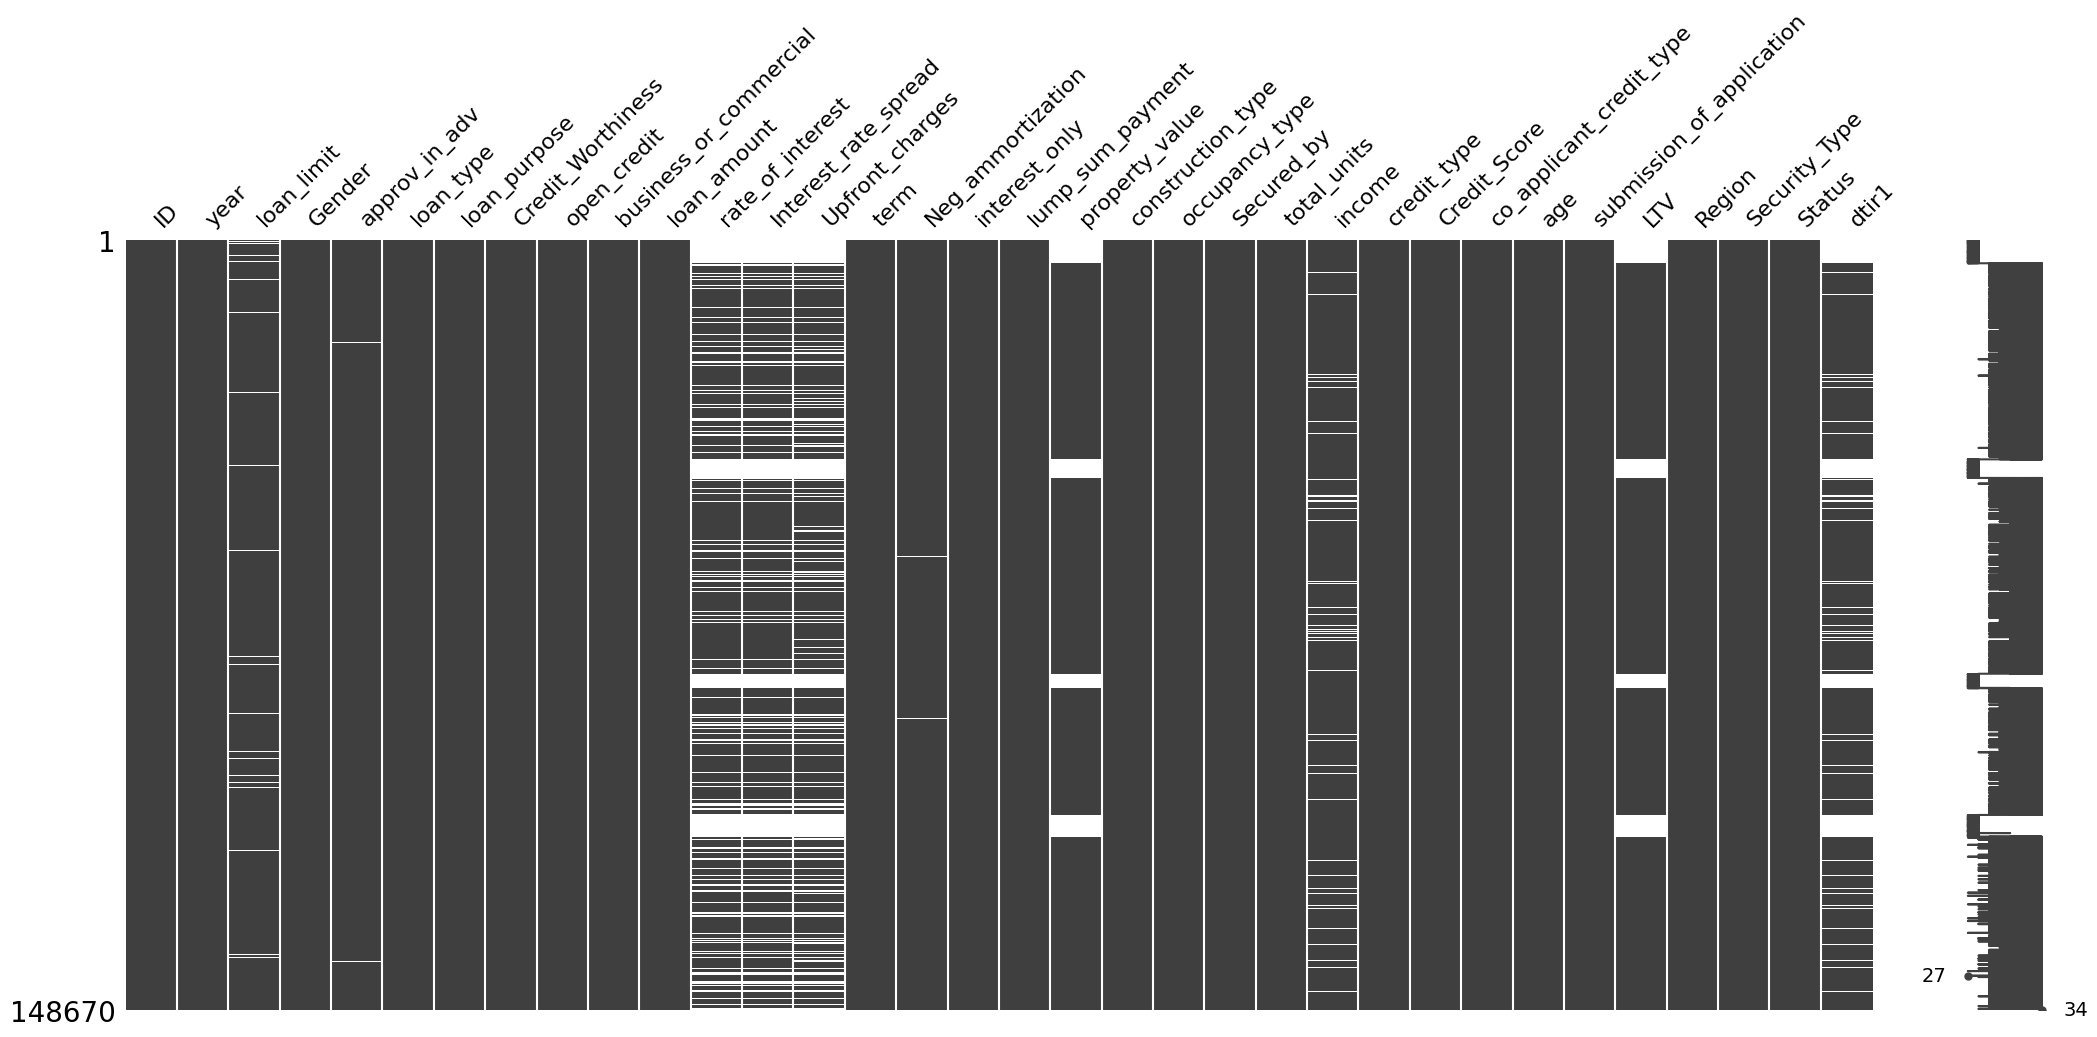

In [6]:
ms.matrix(df)

Pode-se observar algumas colunas com um percentual relevante de valores nulos (acima de 15%). Será realizada a exclusão destas colunas do modelo pelo elevado número de dados missing.

In [7]:
df['year'].unique()

array([2019], dtype=int64)

Pode-se observar que todos os registros são do ano de 2019, logo a informação do ano poderá ser descartada, bem como a informação do ID, pois não são interessantes para o modelo.

Vamos verificar os dados das colunas do tipo objeto.

In [8]:
df.select_dtypes(include=[object]).describe()

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,Neg_ammortization,interest_only,...,construction_type,occupancy_type,Secured_by,total_units,credit_type,co_applicant_credit_type,age,submission_of_application,Region,Security_Type
count,145326,148670,147762,148670,148536,148670,148670,148670,148549,148670,...,148670,148670,148670,148670,148670,148670,148470,148470,148670,148670
unique,2,4,2,3,4,2,2,2,2,2,...,2,3,2,4,4,2,7,2,4,2
top,cf,Male,nopre,type1,p3,l1,nopc,nob/c,not_neg,not_int,...,sb,pr,home,1U,CIB,CIB,45-54,to_inst,North,direct
freq,135348,42346,124621,113173,55934,142344,148114,127908,133420,141560,...,148637,138201,148637,146480,48152,74392,34720,95814,74722,148637


Pode-se notar que todas as variáveis categóricas possuem mais de uma "classe" de valores, portanto nenhuma destas será descartada. Boa parte destas variáveis possuem apenas 2 classes distintas, estas serão transformadas utilizando-se binary encoding. As demais classes serão transformadas utilizando-se a função get_dummies para utilização no modelo.

In [9]:
# dropando colunas que não serão utilizadas neste estudo
df_ajustado = df.drop(columns=['ID', 'year', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'dtir1'])

# Percentual de valores nulos por coluna
print((df_ajustado.isnull().sum() * 100 / len(df_ajustado)).to_string())

loan_limit                    2.249277
Gender                        0.000000
approv_in_adv                 0.610749
loan_type                     0.000000
loan_purpose                  0.090133
Credit_Worthiness             0.000000
open_credit                   0.000000
business_or_commercial        0.000000
loan_amount                   0.000000
term                          0.027578
Neg_ammortization             0.081388
interest_only                 0.000000
lump_sum_payment              0.000000
property_value               10.155378
construction_type             0.000000
occupancy_type                0.000000
Secured_by                    0.000000
total_units                   0.000000
income                        6.154571
credit_type                   0.000000
Credit_Score                  0.000000
co_applicant_credit_type      0.000000
age                           0.134526
submission_of_application     0.134526
LTV                          10.155378
Region                   

## Tratamento de dados nulos

O primeiro passo para o tratamento dos dados nulos, será remover os registros nulos com base nas colunas que possuem menos de 5% de valores nulos.

Posteriormente, com base nas colunas restantes com valor nulo, será aplicado o método fillna para preenchimento dos dados das colunas que possuem mais de 5% de valores nulos (todas numéricas).

In [10]:
# dropando valores nulos
df_ajustado.dropna(subset=['loan_limit', 'approv_in_adv', 'loan_purpose', 'term', 'Neg_ammortization', 'age', 'submission_of_application'], axis=0, inplace=True)

# Percentual de valores nulos por coluna
print((df_ajustado.isnull().sum() * 100 / len(df_ajustado)).to_string())

loan_limit                    0.000000
Gender                        0.000000
approv_in_adv                 0.000000
loan_type                     0.000000
loan_purpose                  0.000000
Credit_Worthiness             0.000000
open_credit                   0.000000
business_or_commercial        0.000000
loan_amount                   0.000000
term                          0.000000
Neg_ammortization             0.000000
interest_only                 0.000000
lump_sum_payment              0.000000
property_value               10.140890
construction_type             0.000000
occupancy_type                0.000000
Secured_by                    0.000000
total_units                   0.000000
income                        6.137194
credit_type                   0.000000
Credit_Score                  0.000000
co_applicant_credit_type      0.000000
age                           0.000000
submission_of_application     0.000000
LTV                          10.140890
Region                   

Para as colunas que ainda possuem valores nulos temos a renda, o valor da propriedade e o LTV (loan to value), que é um ration baseado no valor da propriedade. Estas colunas podem ser representativas para o modelo.

In [11]:
df_ajustado[['income', 'property_value', 'LTV']].describe()

,income,property_value,LTV
count,135108.000000,1.293450e+05,129345.000000
mean,6962.768452,4.994880e+05,72.694362
std,6498.481790,3.612222e+05,40.470213
min,0.000000,8.000000e+03,0.967478
25%,3720.000000,2.780000e+05,60.416667
50%,5760.000000,4.180000e+05,75.111607
75%,8520.000000,6.280000e+05,86.184211
max,578580.000000,1.650800e+07,7831.250000


Como finalidade de manter as informações no dataset, iremos manter estes registros e preenchê-los com o valore médio de cada coluna

In [12]:
colunas = ['income', 'property_value', 'LTV']

# aplicando fillna
for coluna in colunas:
    df_ajustado[coluna].fillna(df_ajustado[coluna].mean(), inplace=True)

print((df_ajustado.isnull().sum() * 100 / len(df_ajustado)).to_string())

loan_limit                   0.0
Gender                       0.0
approv_in_adv                0.0
loan_type                    0.0
loan_purpose                 0.0
Credit_Worthiness            0.0
open_credit                  0.0
business_or_commercial       0.0
loan_amount                  0.0
term                         0.0
Neg_ammortization            0.0
interest_only                0.0
lump_sum_payment             0.0
property_value               0.0
construction_type            0.0
occupancy_type               0.0
Secured_by                   0.0
total_units                  0.0
income                       0.0
credit_type                  0.0
Credit_Score                 0.0
co_applicant_credit_type     0.0
age                          0.0
submission_of_application    0.0
LTV                          0.0
Region                       0.0
Security_Type                0.0
Status                       0.0


In [13]:
df_ajustado.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_amount,143942.0,331816.933209,184225.923796,16500.000000,196500.000000,296500.000000,436500.000000,3576500.00
term,143942.0,335.085930,58.450218,96.000000,360.000000,360.000000,360.000000,360.00
property_value,143942.0,499487.958560,342417.029117,8000.000000,288000.000000,458000.000000,598000.000000,16508000.00
income,143942.0,6962.768452,6295.910910,0.000000,3840.000000,6000.000000,8280.000000,578580.00
Credit_Score,143942.0,699.697649,115.891766,500.000000,599.000000,699.000000,800.000000,900.00
LTV,143942.0,72.694362,38.363337,0.967478,63.144841,72.928994,84.574468,7831.25
Status,143942.0,0.244925,0.430044,0.000000,0.000000,0.000000,0.000000,1.00


In [14]:
df_ajustado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143942 entries, 0 to 148669
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_limit                 143942 non-null  object 
 1   Gender                     143942 non-null  object 
 2   approv_in_adv              143942 non-null  object 
 3   loan_type                  143942 non-null  object 
 4   loan_purpose               143942 non-null  object 
 5   Credit_Worthiness          143942 non-null  object 
 6   open_credit                143942 non-null  object 
 7   business_or_commercial     143942 non-null  object 
 8   loan_amount                143942 non-null  int64  
 9   term                       143942 non-null  float64
 10  Neg_ammortization          143942 non-null  object 
 11  interest_only              143942 non-null  object 
 12  lump_sum_payment           143942 non-null  object 
 13  property_value             14

In [15]:
# resetando o índice
df_ajustado.reset_index(drop=True, inplace=True)

## Variáveis numéricas
Vamos analisar a correlação das variáveis numéricas com a target

<Axes: >

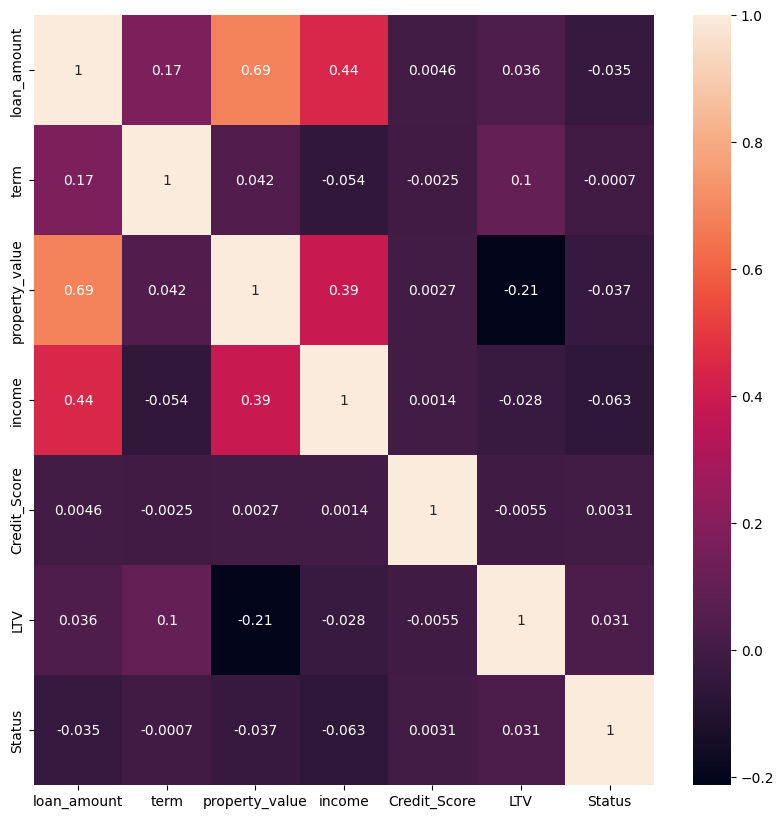

In [16]:
df_numerico = df_ajustado.select_dtypes(include=['int64', 'float64'])
f = plt.figure(figsize= (10, 10))
sns.heatmap(df_numerico.corr(), annot=True)

Podemos observar que todas as variáveis possuem uma correlação baixa em relação à variável Target. Com base nisto, vamos considerar para o modelo variáveis com correlação com a variável target de 0,03 para mais. Desta forma, serão mantidas as colunas loan_amount, property_value, income e LTV.

## Variáveis categóricas
Vamos analisar a composição das variáveis categóricas.

In [17]:
df_categorico = df_ajustado.select_dtypes(include=[object])
df_categorico.describe()

,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,Neg_ammortization,interest_only,...,construction_type,occupancy_type,Secured_by,total_units,credit_type,co_applicant_credit_type,age,submission_of_application,Region,Security_Type
count,143942,143942,143942,143942,143942,143942,143942,143942,143942,143942,...,143942,143942,143942,143942,143942,143942,143942,143942,143942,143942
unique,2,4,2,3,4,2,2,2,2,2,...,2,3,2,4,4,2,7,2,4,2
top,cf,Male,nopre,type1,p3,l1,nopc,nob/c,not_neg,not_int,...,sb,pr,home,1U,CIB,CIB,45-54,to_inst,North,direct
freq,134183,40982,121000,109653,54075,137631,143403,124027,129597,137116,...,143909,133864,143909,141836,46725,72039,33678,92874,72410,143909


In [18]:
for column in df_categorico.columns:
    print(column, df_categorico[column].unique())

loan_limit ['cf' 'ncf']
Gender ['Male' 'Joint' 'Female' 'Sex Not Available']
approv_in_adv ['nopre' 'pre']
loan_type ['type2' 'type3' 'type1']
loan_purpose ['p1' 'p4' 'p3' 'p2']
Credit_Worthiness ['l1' 'l2']
open_credit ['nopc' 'opc']
business_or_commercial ['b/c' 'nob/c']
Neg_ammortization ['not_neg' 'neg_amm']
interest_only ['not_int' 'int_only']
lump_sum_payment ['lpsm' 'not_lpsm']
construction_type ['sb' 'mh']
occupancy_type ['pr' 'ir' 'sr']
Secured_by ['home' 'land']
total_units ['1U' '4U' '2U' '3U']
credit_type ['EQUI' 'CRIF' 'CIB' 'EXP']
co_applicant_credit_type ['EXP' 'CIB']
age ['55-64' '45-54' '35-44' '>74' '25-34' '65-74' '<25']
submission_of_application ['to_inst' 'not_inst']
Region ['North' 'central' 'south' 'North-East']
Security_Type ['direct' 'Indriect']


A variável Gender possui um valor como 'Sex Not Available'. Vamos ajustar este valor para a moda desta variável.

In [19]:
df_categorico['Gender'].replace(['Sex Not Available'],df_categorico['Gender'].mode(),inplace=True)
df_ajustado['Gender'].replace(['Sex Not Available'],df_ajustado['Gender'].mode(),inplace=True)
df_categorico['Gender'].unique()

array(['Male', 'Joint', 'Female'], dtype=object)

Vamos analisar a correlação das variáveis categóricas com a target. O primeiro passo é transformar as variáveis categóricas que possuem apenas 2 classes em valores 0 ou 1. O próximo passo será transformar as demais variáveis categóricas em classes utilizando a função get_dummies.

In [20]:
colunas = [i for i in df_categorico.columns if df_categorico[i].dtype == 'object' and df_categorico[i].nunique() == 2]

for i in colunas:
    df_categorico[i].replace([i for i in df_categorico[i].unique()],[0,1],inplace=True)

In [21]:
df_categorico.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143942 entries, 0 to 143941
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   loan_limit                 143942 non-null  int64 
 1   Gender                     143942 non-null  object
 2   approv_in_adv              143942 non-null  int64 
 3   loan_type                  143942 non-null  object
 4   loan_purpose               143942 non-null  object
 5   Credit_Worthiness          143942 non-null  int64 
 6   open_credit                143942 non-null  int64 
 7   business_or_commercial     143942 non-null  int64 
 8   Neg_ammortization          143942 non-null  int64 
 9   interest_only              143942 non-null  int64 
 10  lump_sum_payment           143942 non-null  int64 
 11  construction_type          143942 non-null  int64 
 12  occupancy_type             143942 non-null  object
 13  Secured_by                 143942 non-null  

In [22]:
df_categorico_dummies = pd.get_dummies(df_categorico)
df_categorico_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143942 entries, 0 to 143941
Data columns (total 45 columns):
 #   Column                     Non-Null Count   Dtype
---  ------                     --------------   -----
 0   loan_limit                 143942 non-null  int64
 1   approv_in_adv              143942 non-null  int64
 2   Credit_Worthiness          143942 non-null  int64
 3   open_credit                143942 non-null  int64
 4   business_or_commercial     143942 non-null  int64
 5   Neg_ammortization          143942 non-null  int64
 6   interest_only              143942 non-null  int64
 7   lump_sum_payment           143942 non-null  int64
 8   construction_type          143942 non-null  int64
 9   Secured_by                 143942 non-null  int64
 10  co_applicant_credit_type   143942 non-null  int64
 11  submission_of_application  143942 non-null  int64
 12  Security_Type              143942 non-null  int64
 13  Gender_Female              143942 non-null  uint8
 14  Gend

Vamos analisar a correlação destas variáveis com a target.

In [23]:
df_categorico_dummies['Status'] = df_ajustado['Status']

<Axes: >

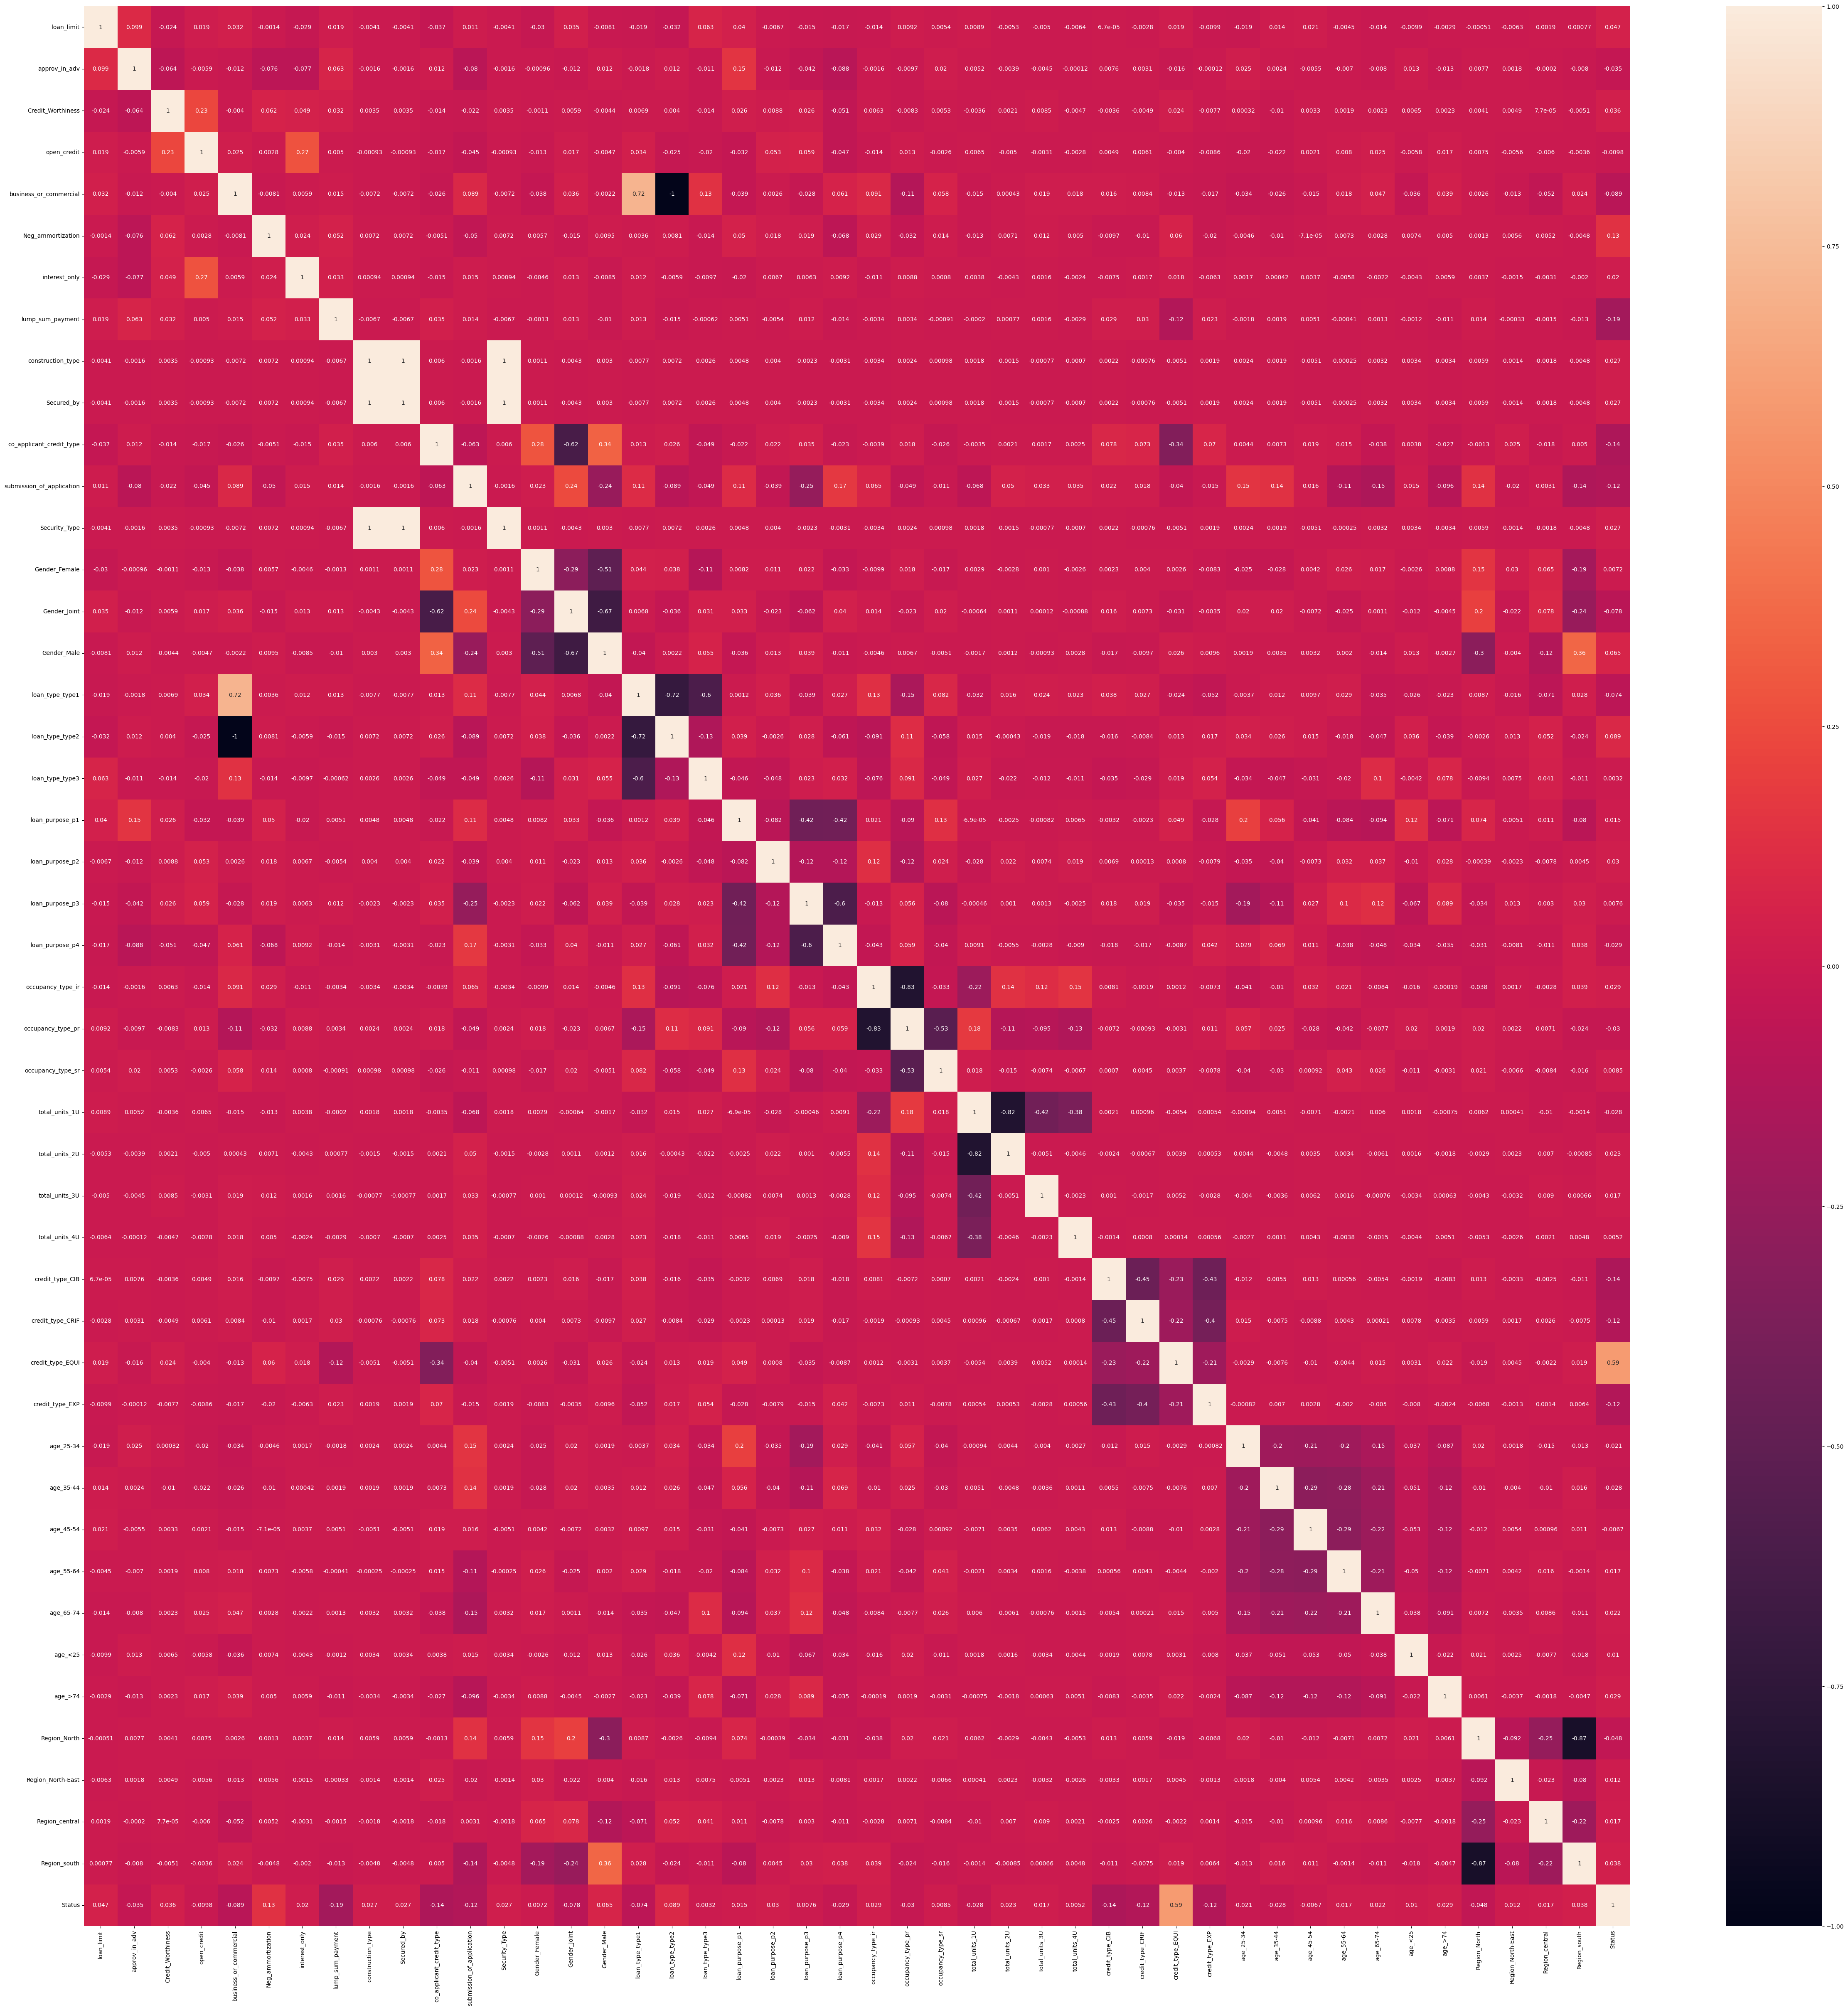

In [24]:
f = plt.figure(figsize= (60, 60))
sns.heatmap(df_categorico_dummies.corr(), annot=True)

In [25]:
df_categorico_dummies.corr()['Status']

loan_limit                   0.046959
approv_in_adv               -0.035223
Credit_Worthiness            0.036316
open_credit                 -0.009790
business_or_commercial      -0.089100
Neg_ammortization            0.133617
interest_only                0.020229
lump_sum_payment            -0.191831
construction_type            0.026588
Secured_by                   0.026588
co_applicant_credit_type    -0.141876
submission_of_application   -0.121380
Security_Type                0.026588
Gender_Female                0.007231
Gender_Joint                -0.078395
Gender_Male                  0.064924
loan_type_type1             -0.074472
loan_type_type2              0.089100
loan_type_type3              0.003203
loan_purpose_p1              0.014562
loan_purpose_p2              0.029583
loan_purpose_p3              0.007628
loan_purpose_p4             -0.029281
occupancy_type_ir            0.029247
occupancy_type_pr           -0.029543
occupancy_type_sr            0.008542
total_units_

In [26]:
df_categorico_dummies.corr()['Status'] > 0.03

loan_limit                    True
approv_in_adv                False
Credit_Worthiness             True
open_credit                  False
business_or_commercial       False
Neg_ammortization             True
interest_only                False
lump_sum_payment             False
construction_type            False
Secured_by                   False
co_applicant_credit_type     False
submission_of_application    False
Security_Type                False
Gender_Female                False
Gender_Joint                 False
Gender_Male                   True
loan_type_type1              False
loan_type_type2               True
loan_type_type3              False
loan_purpose_p1              False
loan_purpose_p2              False
loan_purpose_p3              False
loan_purpose_p4              False
occupancy_type_ir            False
occupancy_type_pr            False
occupancy_type_sr            False
total_units_1U               False
total_units_2U               False
total_units_3U      

In [27]:
 df_categorico_dummies.corr()['Status'] < -0.03

loan_limit                   False
approv_in_adv                 True
Credit_Worthiness            False
open_credit                  False
business_or_commercial        True
Neg_ammortization            False
interest_only                False
lump_sum_payment              True
construction_type            False
Secured_by                   False
co_applicant_credit_type      True
submission_of_application     True
Security_Type                False
Gender_Female                False
Gender_Joint                  True
Gender_Male                  False
loan_type_type1               True
loan_type_type2              False
loan_type_type3              False
loan_purpose_p1              False
loan_purpose_p2              False
loan_purpose_p3              False
loan_purpose_p4              False
occupancy_type_ir            False
occupancy_type_pr            False
occupancy_type_sr            False
total_units_1U               False
total_units_2U               False
total_units_3U      

Utilizando o mesmo critério da análise das variáveis numérios, podemos observar que as variáveis que possuem correlação de 0.03 ou mais relação à Targe são loan_limit, Credit_Worthiness, Neg_ammortization , Gender, loan_type, credit_type, Region, approv_in_adv, business_or_commercial, lump_sum_payment, co_applicant_credit_type, submission_of_application.

Desta forma temos uma definição final para trabalhar o dateset.

## Clusterização de Clientes
Através da utilização do k-means, será realizada uma clusterização dos clientes com base nas variáveis selecionadas. Serão utilizados os métodos do cotovelo (elbow) e Silhouette Score para determinar a quantidade de clusters a serem criados.


In [28]:
# separando os dados
df_cluster = df_ajustado[['loan_amount', 'property_value', 'income', 'LTV', 'loan_limit', 'Credit_Worthiness',
                          'Neg_ammortization' , 'Gender', 'loan_type', 'credit_type', 'Region', 'approv_in_adv',
                          'business_or_commercial', 'lump_sum_payment', 'co_applicant_credit_type', 'submission_of_application']]

df_numerico = df_cluster.select_dtypes(include=['int64', 'float64'])
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df_numerico),columns = df_numerico.columns)
df_categorico = df_cluster.select_dtypes(include=[object])

df_cluster = df_scaled.join(df_categorico)

# binary encoding
colunas = [i for i in df_cluster.columns if df_cluster[i].dtype == 'object' and df_cluster[i].nunique() == 2]
for i in colunas:
    df_cluster[i].replace([i for i in df_cluster[i].unique()],[0,1],inplace=True)

# get_dummies
df_cluster = pd.get_dummies(df_cluster)
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143942 entries, 0 to 143941
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_amount                143942 non-null  float64
 1   property_value             143942 non-null  float64
 2   income                     143942 non-null  float64
 3   LTV                        143942 non-null  float64
 4   loan_limit                 143942 non-null  int64  
 5   Credit_Worthiness          143942 non-null  int64  
 6   Neg_ammortization          143942 non-null  int64  
 7   approv_in_adv              143942 non-null  int64  
 8   business_or_commercial     143942 non-null  int64  
 9   lump_sum_payment           143942 non-null  int64  
 10  co_applicant_credit_type   143942 non-null  int64  
 11  submission_of_application  143942 non-null  int64  
 12  Gender_Female              143942 non-null  uint8  
 13  Gender_Joint               14

In [29]:
# K-Means
kmeans_val_k = [KMeans(n_clusters=k, random_state=seed, n_init='auto').fit(df_cluster)
                for k in range(1, 11)]
inertias = [model.inertia_ for model in kmeans_val_k]
silhouette_scores = [silhouette_score(df_cluster, model.labels_)
                     for model in kmeans_val_k[1:]]

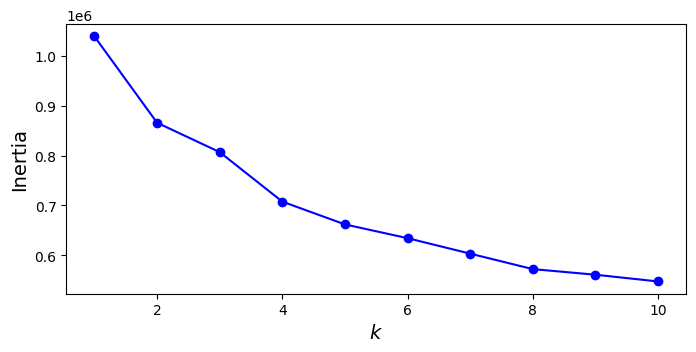

In [30]:
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 11), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

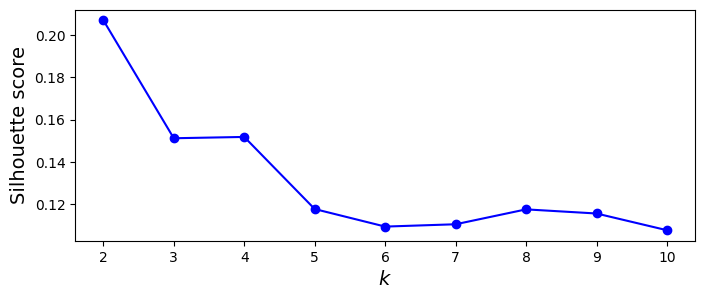

In [31]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 11), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.show()

As análises indicam possíveis bons valores de K em 2 clusters. Vamos verificar os resultados.

In [32]:
kmeans_Standard_k2 = KMeans(n_clusters=2, random_state=seed, n_init='auto')
labels_Standard_k2 = kmeans_Standard_k2.fit_predict(df_cluster)

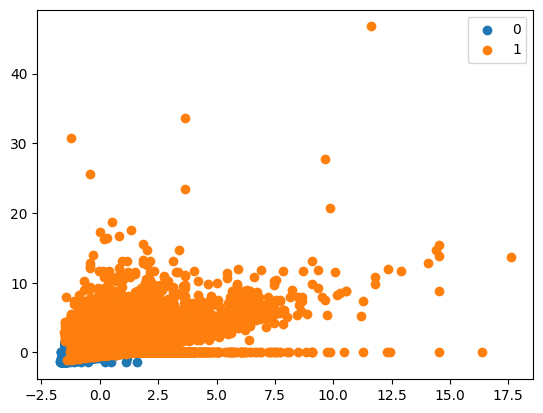

In [33]:
u_labels = np.unique(labels_Standard_k2)
for i in u_labels:
    plt.scatter(df_cluster.iloc[labels_Standard_k2 == i , 0] , df_cluster.iloc[labels_Standard_k2 == i , 1] , label = i)
plt.legend()
plt.show()

Aplicando os 2 clusters na base

In [34]:
# incluindo a informação do cluster no dataset
df_cluster_origin = df_ajustado[['loan_amount', 'property_value', 'income', 'LTV', 'loan_limit', 'Credit_Worthiness',
                          'Neg_ammortization' , 'Gender', 'loan_type', 'credit_type', 'Region', 'approv_in_adv',
                          'business_or_commercial', 'lump_sum_payment', 'co_applicant_credit_type', 'submission_of_application']]

df_cluster['Cluster'] = labels_Standard_k2
df_cluster_origin['Cluster'] = labels_Standard_k2

C:\Users\Cristian\AppData\Local\Temp\ipykernel_26140\776022022.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster_origin['Cluster'] = labels_Standard_k2


In [35]:
df_cluster_origin

,loan_amount,property_value,income,LTV,loan_limit,Credit_Worthiness,Neg_ammortization,Gender,loan_type,credit_type,Region,approv_in_adv,business_or_commercial,lump_sum_payment,co_applicant_credit_type,submission_of_application,Cluster
0,206500,4.994880e+05,4980.000000,72.694362,cf,l1,not_neg,Male,type2,EQUI,North,nopre,b/c,lpsm,EXP,to_inst,0
1,466500,4.994880e+05,0.000000,72.694362,cf,l1,not_neg,Male,type3,EQUI,North,nopre,nob/c,not_lpsm,EXP,to_inst,0
2,656500,4.994880e+05,8640.000000,72.694362,cf,l1,not_neg,Male,type2,EQUI,North,nopre,b/c,not_lpsm,EXP,to_inst,1
3,106500,4.994880e+05,1680.000000,72.694362,cf,l1,not_neg,Male,type1,EQUI,central,nopre,nob/c,lpsm,EXP,to_inst,0
4,406500,4.994880e+05,7560.000000,72.694362,cf,l1,not_neg,Male,type3,EQUI,North,nopre,nob/c,not_lpsm,EXP,not_inst,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143937,246500,4.280000e+05,4800.000000,57.593458,cf,l1,not_neg,Male,type1,CRIF,south,nopre,nob/c,not_lpsm,CIB,to_inst,0
143938,246500,4.280000e+05,7920.000000,57.593458,cf,l1,not_neg,Male,type1,CRIF,south,nopre,nob/c,not_lpsm,EXP,to_inst,0
143939,656500,7.080000e+05,11700.000000,92.725989,cf,l1,neg_amm,Male,type2,CIB,south,nopre,b/c,not_lpsm,EXP,to_inst,1
143940,656500,7.080000e+05,6962.768452,92.725989,cf,l1,neg_amm,Male,type3,EXP,south,nopre,nob/c,not_lpsm,CIB,to_inst,1


## Características dos Clusters

Vamos analisar algumas características dos clusters criados

In [36]:
df_cluster0 = df_cluster_origin[df_cluster['Cluster']==0]
df_cluster1 = df_cluster_origin[df_cluster['Cluster']==1]

In [37]:
df_cluster0.describe().T.applymap(lambda x: f"{x:,.2f}")

,count,mean,std,min,25%,50%,75%,max
loan_amount,"97,839.00","238,406.40","95,648.66","16,500.00","166,500.00","236,500.00","306,500.00","636,500.00"
property_value,"97,839.00","353,940.25","145,175.59","8,000.00","238,000.00","348,000.00","478,000.00","1,448,000.00"
income,"97,839.00","5,123.83","2,679.83",0.00,"3,240.00","4,740.00","6,840.00","38,520.00"
LTV,"97,839.00",74.31,44.70,5.10,65.68,74.04,86.07,"7,831.25"
Cluster,"97,839.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [38]:
for column in df_cluster0.select_dtypes(include=[object]).columns:
    print(column, df_categorico[column].value_counts())
    print('_______________')

loan_limit cf     134183
ncf      9759
Name: loan_limit, dtype: int64
_______________
Credit_Worthiness l1    137631
l2      6311
Name: Credit_Worthiness, dtype: int64
_______________
Neg_ammortization not_neg    129597
neg_amm     14345
Name: Neg_ammortization, dtype: int64
_______________
Gender Male      77351
Joint     40192
Female    26399
Name: Gender, dtype: int64
_______________
loan_type type1    109653
type2     19915
type3     14374
Name: loan_type, dtype: int64
_______________
credit_type CIB     46725
CRIF    42554
EXP     40066
EQUI    14597
Name: credit_type, dtype: int64
_______________
Region North         72410
south         61922
central        8404
North-East     1206
Name: Region, dtype: int64
_______________
approv_in_adv nopre    121000
pre       22942
Name: approv_in_adv, dtype: int64
_______________
business_or_commercial nob/c    124027
b/c       19915
Name: business_or_commercial, dtype: int64
_______________
lump_sum_payment not_lpsm    140558
lpsm          

In [39]:
df_cluster1.describe().T.applymap(lambda x: f"{x:,.2f}")

,count,mean,std,min,25%,50%,75%,max
loan_amount,"46,103.00","530,051.18","169,514.96","46,500.00","436,500.00","496,500.00","606,500.00","3,576,500.00"
property_value,"46,103.00","808,366.82","425,424.73","108,000.00","568,000.00","698,000.00","898,000.00","16,508,000.00"
income,"46,103.00","10,865.34","9,279.69",0.00,"6,962.77","9,000.00","12,240.00","578,580.00"
LTV,"46,103.00",69.26,18.37,0.97,59.03,72.69,80.34,143.65
Cluster,"46,103.00",1.00,0.00,1.00,1.00,1.00,1.00,1.00


In [40]:
for column in df_cluster1.select_dtypes(include=[object]).columns:
    print(column, df_categorico[column].value_counts())
    print('_______________')

loan_limit cf     134183
ncf      9759
Name: loan_limit, dtype: int64
_______________
Credit_Worthiness l1    137631
l2      6311
Name: Credit_Worthiness, dtype: int64
_______________
Neg_ammortization not_neg    129597
neg_amm     14345
Name: Neg_ammortization, dtype: int64
_______________
Gender Male      77351
Joint     40192
Female    26399
Name: Gender, dtype: int64
_______________
loan_type type1    109653
type2     19915
type3     14374
Name: loan_type, dtype: int64
_______________
credit_type CIB     46725
CRIF    42554
EXP     40066
EQUI    14597
Name: credit_type, dtype: int64
_______________
Region North         72410
south         61922
central        8404
North-East     1206
Name: Region, dtype: int64
_______________
approv_in_adv nopre    121000
pre       22942
Name: approv_in_adv, dtype: int64
_______________
business_or_commercial nob/c    124027
b/c       19915
Name: business_or_commercial, dtype: int64
_______________
lump_sum_payment not_lpsm    140558
lpsm          

Podemos notar que os clientes do cluster 0 possuem uma renda mais alta e propriedades mais caras do que os clientes no cluster 0, indicando maior potencial financeiro.
Vamos classificar o grupo de clientes então em 2 modalidades:
* Cluster 0 --> Ouro
* Cluster 1 --> Prata

## Modelo de Classificação dos Clusters

Vamos criar um modelo para realizar a classificação dos clusters, agora que temos a classificação dentro da base de dados.
Iremos utilizar o Random Forest neste processo.

In [41]:
# separação da base em treino e teste
X = df_cluster.iloc[:,:-1]
y_cluster = df_cluster.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y_cluster, test_size=0.2, random_state=seed)

### Random Forest

In [42]:
# criando o modelo
rf = RandomForestClassifier(random_state = seed, n_jobs=-1)

# Grid de parâmetros para o modelo
params = {
    'n_estimators': [50,100,200],
    'max_depth': [None,4,8,10,30],
    'min_samples_leaf': [1,10,20]
}

In [43]:
# Grid search
grid = GridSearchCV(rf, param_grid=params, scoring="accuracy")
grid.fit(X_train, y_train)
print('Random Forest')
print('Acurácia do treino', grid.best_score_)

Random Forest
Acurácia do treino 0.9913159116298402


In [44]:
print('Random Forest - Melhor Modelo')
print(grid.best_estimator_)

Random Forest - Melhor Modelo
RandomForestClassifier(max_depth=30, n_estimators=200, n_jobs=-1,
                       random_state=42)


In [45]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print('Random Forest')
print('Acurácia do teste',accuracy_score(y_test, y_pred))

Random Forest
Acurácia do teste 0.9920108374726458


## Modelo Classificação de inadimplência

Vamos criar um modelo para realizar a classificação da propenção à inadimplência.
Primeiramente será realizada a nova limpeza da base e ajustes nos dados para que sejam trabalhados no novo modelo.
Iremos utilizar 3 modelos diferentes (Random Forest, XGBoost e Light GBM) e identificar qual dentre eles é o melhor modelo para esta classificação.

In [46]:
# separando os dados
df_modeloInad = df_ajustado[['loan_amount', 'property_value', 'income', 'LTV', 'loan_limit', 'Credit_Worthiness',
                          'Neg_ammortization' , 'Gender', 'loan_type', 'credit_type', 'Region', 'approv_in_adv',
                          'business_or_commercial', 'lump_sum_payment', 'co_applicant_credit_type', 'submission_of_application']]

df_numerico = df_modeloInad.select_dtypes(include=['int64', 'float64'])
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df_numerico),columns = df_numerico.columns)
df_categorico = df_modeloInad.select_dtypes(include=[object])
df_modeloInad = df_scaled.join(df_categorico)
df_modeloInad['Status'] = df_ajustado['Status']

# binary encoding
colunas = [i for i in df_modeloInad.columns if df_modeloInad[i].dtype == 'object' and df_modeloInad[i].nunique() == 2]
for i in colunas:
    df_modeloInad[i].replace([i for i in df_modeloInad[i].unique()],[0,1],inplace=True)

# get_dummies
df_modeloInad = pd.get_dummies(df_modeloInad)
df_modeloInad.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143942 entries, 0 to 143941
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_amount                143942 non-null  float64
 1   property_value             143942 non-null  float64
 2   income                     143942 non-null  float64
 3   LTV                        143942 non-null  float64
 4   loan_limit                 143942 non-null  int64  
 5   Credit_Worthiness          143942 non-null  int64  
 6   Neg_ammortization          143942 non-null  int64  
 7   approv_in_adv              143942 non-null  int64  
 8   business_or_commercial     143942 non-null  int64  
 9   lump_sum_payment           143942 non-null  int64  
 10  co_applicant_credit_type   143942 non-null  int64  
 11  submission_of_application  143942 non-null  int64  
 12  Status                     143942 non-null  int64  
 13  Gender_Female              14

In [47]:
df_modeloInad['Status'].value_counts()

0    108687
1     35255
Name: Status, dtype: int64

Podemos observar um desbalanceamento na variável target. Vamos utilizar o SMOTE para balancear os valores

In [48]:
smote = SMOTE(random_state = seed)
X_smote, y_smote = smote.fit_resample(df_modeloInad.drop('Status', axis = 1), df_modeloInad['Status'])
df_modeloInad = pd.concat([X_smote, y_smote], axis = 1)
df_modeloInad['Status'].value_counts()

1    108687
0    108687
Name: Status, dtype: int64

In [49]:
# separação da base em treino e teste
X = df_modeloInad.drop(columns=['Status'])
y_inad = df_modeloInad['Status']
X_train, X_test, y_train, y_test = train_test_split(X, y_inad, test_size=0.2, random_state=seed)

### Random Forest

In [50]:
# criando o modelo
rf = RandomForestClassifier(random_state = seed, n_jobs=-1)

# Grid de parâmetros para o modelo
params = {
    'n_estimators': [50,100,200],
    'max_depth': [None,4,8,10,30],
    'min_samples_leaf': [1,10,20]
}

In [51]:
# Grid search
grid = GridSearchCV(rf, param_grid=params, scoring="accuracy")
grid.fit(X_train, y_train)
print('Random Forest')
print('Acurácia do treino', grid.best_score_)

Random Forest
Acurácia do treino 0.861988860376754


In [52]:
print('Random Forest - Melhor Modelo')
print(grid.best_estimator_)

Random Forest - Melhor Modelo
RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)


In [53]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print('Random Forest')
print('Acurácia do teste',accuracy_score(y_test, y_pred))

Random Forest
Acurácia do teste 0.8689361702127659


### XGBoost

In [54]:
# criando o modelo
xgb = XGBClassifier(random_state = seed, verbosity=0, n_jobs=-1)

# Grid de parâmetros para o modelo
params = {
    'n_estimators': [50,100,200],
    'max_depth': [4,8,10,30],
    'eta': [0.1,0.3,0.5]
}

# Grid search
grid = GridSearchCV(xgb, param_grid=params, scoring="accuracy")
grid.fit(X_train, y_train)
print('XGBoost')
print('Acurácia do treino', grid.best_score_)

XGBoost
Acurácia do treino 0.8782224350284679


In [55]:
print('XGBoost - Melhor Modelo')
print(grid.best_estimator_)

XGBoost - Melhor Modelo
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.3, eval_metric=None,
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=-1, num_parallel_tree=None, ...)


In [56]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print('Random Forest')
print('Acurácia do teste',accuracy_score(y_test, y_pred))

Random Forest
Acurácia do teste 0.8815411155836688


### Light GBM

In [57]:
# Criando o modelo
lgbm = LGBMClassifier(random_state = seed, n_jobs=-1, verbose=-1)

# Grid de parâmetros para o modelo
params = {
    'n_estimators': [50,100,200],
    'max_depth': [-1,4,8,10,30],
    'learning_rate': [0.1,0.3,0.5]
}

# Grid search
grid = GridSearchCV(lgbm, param_grid=params, scoring="accuracy")
grid.fit(X_train, y_train)
print('Light GBM')
print('Acurácia do treino', grid.best_score_)

Light GBM
Acurácia do treino 0.9058994001737514


In [58]:
print('Light GBM - Melhor Modelo')
print(grid.best_estimator_)

Light GBM - Melhor Modelo
LGBMClassifier(learning_rate=0.3, max_depth=10, n_estimators=200, n_jobs=-1,
               random_state=42, verbose=-1)


In [59]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print('Light GBM')
print('Acurácia do teste',accuracy_score(y_test, y_pred))

Light GBM
Acurácia do teste 0.9062679700977573


## Conclusão
Iremos utilizar o Random Forest como opção de modelo para este estudo, pois não está apresentando overfit e a diferença para o XGBoost é pequena. A versão resumida estará no arquivo treina.py, que fará a geração dos modelos finais deste projeto.